# Three-stage trigger optimization

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import ocha_stratus as stratus
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import optuna
from tqdm.auto import tqdm

from src.datasources import ibtracs
from src.datasources.ibtracs import knots2cat
from src.constants import *

In [3]:
df_storms = ibtracs.load_storms()
cols = ["sid", "atcf_id", "name"]
df_storms = df_storms[
    (df_storms["sid"].str[:4].astype(int) >= 2000)
    & (df_storms["genesis_basin"] == "NA")
][cols]
df_storms["atcf_id"] = df_storms["atcf_id"].str.lower()

In [4]:
blob_name = f"{PROJECT_PREFIX}/processed/impact/emdat_cerf_upto2024.parquet"
df_impact = stratus.load_parquet_from_blob(blob_name)
df_impact["cerf"] = ~df_impact["Amount in US$"].isnull()
cols = [
    "sid",
    "cerf",
    "Total Affected",
    "Total Deaths",
    "Total Damage, Adjusted ('000 US$)",
    "Amount in US$",
]
df_impact = df_impact[cols]
df_impact.loc[df_impact["sid"] == IKE, "Total Affected"] = 2.6e6

In [5]:
blob_name = (
    f"{PROJECT_PREFIX}/processed/storm_stats/zma_stats_imerg_quantiles.parquet"
)

df_stats_obsv = stratus.load_parquet_from_blob(blob_name)

In [6]:
blob_name = f"{PROJECT_PREFIX}/processed/storm_stats/zma_stats.parquet"

df_stats_obsv_meanonly = stratus.load_parquet_from_blob(blob_name)

In [7]:
drop_cols = [
    x
    for x in df_stats_obsv
    if any([s in x for s in ["_total", "_abv", "_roll3", "_landfall"]])
]
df_stats_obsv = df_stats_obsv.drop(columns=drop_cols)

In [8]:
df_stats_obsv = df_stats_obsv.merge(
    df_stats_obsv_meanonly[["sid", "max_roll2_mean"]]
).drop(columns=[x for x in df_stats_obsv if "valid" in x])

In [9]:
blob_name = blob_name = (
    f"{PROJECT_PREFIX}/processed/nhc/monitors_nhc_chirpsgefs.parquet"
)
df_monitors_fcast = stratus.load_parquet_from_blob(blob_name)

In [10]:
df_stats_fcast = (
    df_monitors_fcast[df_monitors_fcast["lt_name"] == "action"]
    .groupby("atcf_id")
    .max()
    .reset_index()
    .dropna()
    .drop(columns=["issue_time", "lt_name"])
)

In [11]:
df_stats = (
    df_impact.merge(df_storms, how="left")
    .merge(df_stats_fcast, how="left")
    .merge(
        df_stats_obsv.rename(
            columns={x: x.replace("roll2", "obsv") for x in df_stats_obsv}
            | {"max_roll2_mean": "mean_obsv", "wind_speed_max": "wind_obsv"}
        ),
        how="left",
    )
)
df_stats["year"] = df_stats["sid"].str[:4]

int_cols = [
    "year",
    # "wind",
    # "wind_obsv",
    "Total Affected",
    "Total Deaths",
    "Total Damage, Adjusted ('000 US$)",
    "Amount in US$",
]
df_stats[int_cols] = df_stats[int_cols].fillna(0)
df_stats[int_cols] = df_stats[int_cols].astype(int)

In [92]:
blob_name = f"{PROJECT_PREFIX}/processed/fcast_obsv_combined_stats.parquet"
stratus.upload_parquet_to_blob(df_stats, blob_name)

## Optimization

In [12]:
target_years = 7

In [67]:
impact_cols = [
    "Total Affected",
    "Total Deaths",
    "Total Damage, Adjusted ('000 US$)",
    "Amount in US$",
    "cerf",
]

In [71]:
# fcast_rain_cols = ["mean"]
# fcast_rain_cols = ["mean"] + [f"q{x}" for x in [50, 80, 90, 95, 99]]
fcast_rain_cols = ["mean"] + [f"q{x}" for x in [50, 80, 95]]

In [72]:
obsv_rain_cols = [x + "_obsv" for x in fcast_rain_cols]

In [73]:
fcast_rain_cols

['mean', 'q50', 'q80', 'q95']

In [82]:
rows = []

count = 0
for fcast_wind_thresh in tqdm(
    df_stats["wind"].unique(), disable=tqdm_level < 1
):
    # continue
    for obsv_wind_thresh in tqdm(
        df_stats["wind_obsv"].unique(), disable=tqdm_level < 2
    ):
        dff_wind = df_stats[
            (df_stats["wind"] >= fcast_wind_thresh)
            | (df_stats["wind_obsv"] >= obsv_wind_thresh)
        ]
        # if filtering already limits to too few years, skip
        # since we know that further filtering will only result in lower number
        if dff_wind["year"].nunique() < target_years:
            continue
        for fcast_rain_col in fcast_rain_cols:
            for fcast_rain_thresh in df_stats[fcast_rain_col].unique():
                for obsv_rain_col in obsv_rain_cols:
                    for obsv_rain_thresh in df_stats[obsv_rain_col].unique():
                        count += 1
                        # continue
                        triggered_fcast = (
                            df_stats["wind"] >= fcast_wind_thresh
                        ) & (df_stats[fcast_rain_col] >= fcast_rain_thresh)
                        triggered_obsv = (
                            df_stats["wind_obsv"] >= obsv_wind_thresh
                        ) & (df_stats[obsv_rain_col] >= obsv_rain_thresh)

                        dff_triggered = df_stats[
                            triggered_fcast | triggered_obsv
                        ]
                        if dff_triggered["year"].nunique() == target_years:
                            row_out = dff_triggered[impact_cols].sum()
                            row_out["fcast_wind"] = fcast_wind_thresh
                            row_out["fcast_rain_col"] = fcast_rain_col
                            row_out["fcast_rain_thresh"] = fcast_rain_thresh
                            row_out["obsv_wind"] = obsv_wind_thresh
                            row_out["obsv_rain_col"] = obsv_rain_col
                            row_out["obsv_rain_thresh"] = obsv_rain_thresh
                            row_out["n_years_fcast"] = df_stats[
                                triggered_fcast
                            ]["year"].nunique()
                            row_out["n_years_obsv"] = df_stats[triggered_obsv][
                                "year"
                            ].nunique()
                            rows.append(row_out)

  0%|          | 0/17 [00:00<?, ?it/s]

In [85]:
count

3897600

In [83]:
df_metrics = pd.concat(rows, axis=1).T

In [87]:
df_metrics.sort_values("Total Affected", ascending=False)

,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,cerf,fcast_wind,fcast_rain_col,fcast_rain_thresh,obsv_wind,obsv_rain_col,obsv_rain_thresh,n_years_fcast,n_years_obsv
293340,28457558.0,53.0,4971882.0,32229929.0,5.0,45.0,q50,65.06957,85.0,q80_obsv,96.369003,4,7
201114,28457558.0,53.0,4971882.0,32229929.0,5.0,35.0,mean,69.391884,75.0,q80_obsv,96.369003,4,7
283432,28457558.0,53.0,4971882.0,32229929.0,5.0,45.0,q50,65.06957,90.0,q80_obsv,97.080002,4,7
218431,28457558.0,53.0,4971882.0,32229929.0,5.0,60.0,q50,65.06957,90.0,q80_obsv,96.369003,4,7
232786,28457558.0,53.0,4971882.0,32229929.0,5.0,65.0,q50,65.06957,90.0,q80_obsv,96.369003,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293006,9079122.0,45.0,7020401.0,10875489.0,2.0,45.0,q95,220.65988,35.0,q95_obsv,224.965729,3,5
315052,9079122.0,45.0,7020401.0,10875489.0,2.0,75.0,q95,220.65988,30.0,q95_obsv,224.965729,3,5
315053,9079122.0,45.0,7020401.0,10875489.0,2.0,75.0,q95,220.65988,30.0,q95_obsv,224.783478,3,6
124293,9079122.0,45.0,7020401.0,10875489.0,2.0,100.0,q95,220.65988,30.0,q95_obsv,224.783478,2,6


In [88]:
df_metrics.sort_values("cerf", ascending=False)

,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,cerf,fcast_wind,fcast_rain_col,fcast_rain_thresh,obsv_wind,obsv_rain_col,obsv_rain_thresh,n_years_fcast,n_years_obsv
243657,25002636.0,52.0,10958627.0,34070208.0,6.0,65.0,q95,241.6073,75.0,q50_obsv,45.957497,2,6
218764,25002636.0,52.0,10958627.0,34070208.0,6.0,60.0,q95,241.6073,90.0,q50_obsv,45.957497,2,6
313634,25002636.0,52.0,10958627.0,34070208.0,6.0,75.0,q95,241.6073,105.0,q50_obsv,45.957497,2,5
255760,25002636.0,52.0,10958627.0,34070208.0,6.0,125.0,q95,201.25024,100.0,q50_obsv,45.957497,2,6
255748,25002636.0,52.0,10958627.0,34070208.0,6.0,125.0,q95,241.6073,100.0,q50_obsv,45.957497,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223089,15191241.0,34.0,5128903.0,12879554.0,2.0,60.0,q50,47.932934,135.0,q80_obsv,103.724991,7,1
223088,15191241.0,34.0,5128903.0,12879554.0,2.0,60.0,q50,47.932934,135.0,q80_obsv,169.009995,7,0
223086,15191241.0,34.0,5128903.0,12879554.0,2.0,60.0,q50,47.932934,135.0,q80_obsv,103.079987,7,1
223084,15191241.0,34.0,5128903.0,12879554.0,2.0,60.0,q50,47.932934,135.0,q80_obsv,NaN,7,0


In [47]:
df_metrics[df_metrics["Total Affected"] == df_metrics["Total Affected"].max()]

,Total Affected,fcast_wind,fcast_rain_col,fcast_rain_thresh,obsv_wind,obsv_rain_col,obsv_rain_thresh
107973,28457558.0,35.0,q50,65.06957,90.0,q80_obsv,97.080002
107974,28457558.0,35.0,q50,65.06957,90.0,q80_obsv,96.369003
113005,28457558.0,35.0,q50,65.06957,100.0,q80_obsv,97.080002
113006,28457558.0,35.0,q50,65.06957,100.0,q80_obsv,96.369003
114059,28457558.0,35.0,q50,65.06957,85.0,q80_obsv,97.080002
114060,28457558.0,35.0,q50,65.06957,85.0,q80_obsv,96.369003
114423,28457558.0,35.0,q50,65.06957,75.0,q80_obsv,97.080002
114424,28457558.0,35.0,q50,65.06957,75.0,q80_obsv,96.369003
123640,28457558.0,60.0,q50,65.06957,90.0,q80_obsv,97.080002
123641,28457558.0,60.0,q50,65.06957,90.0,q80_obsv,96.369003


In [90]:
blob_name = (
    f"{PROJECT_PREFIX}/processed/fcast_obsv_combined_trigger_metrics.parquet"
)
stratus.upload_parquet_to_blob(df_metrics, blob_name)

## Using `optima`

Can ignore for now, didn't use

[I 2025-06-27 07:36:03,577] A new study created in memory with name: no-name-4c6c1737-d50d-42b3-a860-2d703c409403



🔍 Optimizing for impact column: Total Affected


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-06-27 07:36:03,584] Trial 0 finished with value: -21599867.0 and parameters: {'fcast_wind_thresh': 35, 'obsv_wind_thresh': 85, 'fcast_rain_col': 'q95', 'obsv_rain_col': 'q50_obsv', 'fcast_rain_thresh': 167, 'obsv_rain_thresh': 61}. Best is trial 0 with value: -21599867.0.
[I 2025-06-27 07:36:03,585] Trial 1 pruned. 
[I 2025-06-27 07:36:03,587] Trial 2 pruned. 
[I 2025-06-27 07:36:03,589] Trial 3 pruned. 
[I 2025-06-27 07:36:03,590] Trial 4 pruned. 
[I 2025-06-27 07:36:03,592] Trial 5 pruned. 
[I 2025-06-27 07:36:03,594] Trial 6 pruned. 
[I 2025-06-27 07:36:03,596] Trial 7 pruned. 
[I 2025-06-27 07:36:03,597] Trial 8 finished with value: -21444562.0 and parameters: {'fcast_wind_thresh': 100, 'obsv_wind_thresh': 90, 'fcast_rain_col': 'q95', 'obsv_rain_col': 'q95_obsv', 'fcast_rain_thresh': 254, 'obsv_rain_thresh': 177}. Best is trial 0 with value: -21599867.0.
[I 2025-06-27 07:36:03,599] Trial 9 pruned. 
[I 2025-06-27 07:36:03,608] Trial 10 finished with value: -21596622.0 and pa

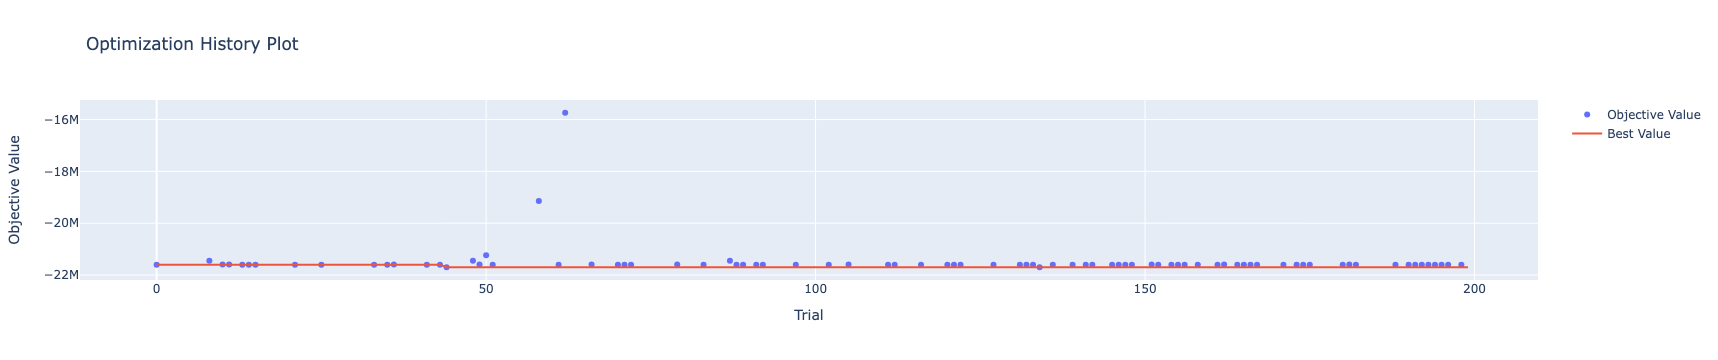


📊 Optimization results:
       impact_col  best_score  fcast_wind_thresh  obsv_wind_thresh  \
0  Total Affected  21699867.0                 40                65   

  fcast_rain_col obsv_rain_col  fcast_rain_thresh  obsv_rain_thresh  
0            q95      q50_obsv                143                75  


In [20]:
# --- Storage for all results ---
results_rows = []

# --- Loop over each impact column ---
for impact_col in impact_cols:
    print(f"\n🔍 Optimizing for impact column: {impact_col}")

    def objective(trial):
        # Sample threshold values
        fcast_wind_thresh = trial.suggest_int(
            "fcast_wind_thresh",
            int(df_stats["wind"].min()),
            int(df_stats["wind"].max()),
            step=5,
        )
        obsv_wind_thresh = trial.suggest_int(
            "obsv_wind_thresh",
            int(df_stats["wind_obsv"].min()),
            int(df_stats["wind_obsv"].max()),
            step=5,
        )
        fcast_rain_col = trial.suggest_categorical(
            "fcast_rain_col", fcast_rain_cols
        )
        obsv_rain_col = trial.suggest_categorical(
            "obsv_rain_col", obsv_rain_cols
        )
        fcast_rain_thresh = trial.suggest_int(
            "fcast_rain_thresh",
            int(df_stats[fcast_rain_col].min()),
            int(df_stats[fcast_rain_col].max()),
        )
        obsv_rain_thresh = trial.suggest_int(
            "obsv_rain_thresh",
            int(df_stats[obsv_rain_col].min()),
            int(df_stats[obsv_rain_col].max()),
        )

        # Filtering logic (trigger condition)
        dff_triggered = df_stats[
            (
                (df_stats["wind"] >= fcast_wind_thresh)
                & (df_stats[fcast_rain_col] >= fcast_rain_thresh)
            )
            | (
                (df_stats["wind_obsv"] >= obsv_wind_thresh)
                & (df_stats[obsv_rain_col] >= obsv_rain_thresh)
            )
        ]

        # Skip if not enough years are represented
        if dff_triggered["year"].nunique() != target_years:
            raise optuna.exceptions.TrialPruned()

        # Maximize the sum of the selected impact column
        score = dff_triggered[impact_col].sum()
        return -score  # Optuna minimizes, so negate

    # Create and run study
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200, show_progress_bar=True)
    optuna.visualization.plot_optimization_history(study).show()
    # Store result as a row dict
    row = {
        "impact_col": impact_col,
        "best_score": -study.best_value,
        **study.best_params,
    }
    results_rows.append(row)

# --- Final results DataFrame ---
results_df = pd.DataFrame(results_rows)
print("\n📊 Optimization results:")
print(results_df)

In [32]:
optuna.visualization.plot_optimization_history(study).show()

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [30]:
for impact_col, row in results_df.set_index("impact_col").iterrows():
    df_disp = df_stats.copy()
    fcast_wind_thresh = row["fcast_wind_thresh"]
    obsv_wind_thresh = row["obsv_wind_thresh"]
    fcast_rain_col = row["fcast_rain_col"]
    fcast_rain_thresh = row["fcast_rain_thresh"]
    obsv_rain_col = row["obsv_rain_col"]
    obsv_rain_thresh = row["obsv_rain_thresh"]
    df_disp["trig"] = (
        (df_stats["wind"] >= fcast_wind_thresh)
        & (df_stats[fcast_rain_col] >= fcast_rain_thresh)
    ) | (
        (df_stats["wind_obsv"] >= obsv_wind_thresh)
        & (df_stats[obsv_rain_col] >= obsv_rain_thresh)
    )
    print(impact_col)
    print(row)
    display(df_disp.sort_values(impact_col, ascending=False))

Total Affected
best_score           24992721.0
fcast_wind_thresh           115
obsv_wind_thresh            115
fcast_rain_col              q50
obsv_rain_col          q95_obsv
fcast_rain_thresh            13
obsv_rain_thresh            360
Name: Total Affected, dtype: object


,sid,cerf,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,atcf_id,name,mean,q50,...,wind,wind_obsv,q50_obsv,q80_obsv,q90_obsv,q95_obsv,q99_obsv,mean_obsv,year,trig
17,2017242N16333,True,10000000,10,644720,7999469,al112017,IRMA,96.329570,101.040480,...,145.0,145.0,86.267494,145.037994,174.386002,191.268250,235.662643,82.463090,2017,True
0,2001303N13276,False,5900012,5,165279,0,al152001,MICHELLE,52.256130,42.807594,...,120.0,120.0,76.807495,196.168976,275.528503,316.773743,379.588867,120.507424,2001,True
28,2024309N13283,True,4000000,0,0,5999888,al182024,RAFAEL,26.405380,22.381561,...,100.0,100.0,34.349998,98.341003,129.086502,145.917496,214.011810,49.361216,2024,False
24,2022266N12294,True,3200000,3,25000,7827734,al092022,IAN,46.000458,41.205720,...,120.0,110.0,47.079998,97.080002,119.258492,138.438248,170.793289,53.925203,2022,True
12,2008245N17323,True,2600000,7,2038909,4880085,al092008,IKE,101.455860,94.025665,...,125.0,115.0,121.077492,169.009995,196.209976,217.795731,272.717255,114.313233,2008,True
5,2005186N12299,False,2500000,16,2097974,0,al042005,DENNIS,78.946040,80.616330,...,130.0,130.0,87.290009,153.271011,183.921524,224.965729,309.937012,97.973385,2005,True
11,2008238N13293,True,450019,0,2816413,2487431,al072008,GUSTAV,59.768433,46.652534,...,135.0,135.0,45.957497,71.269997,86.456490,99.083984,120.336998,45.797444,2008,True
27,2024293N21294,True,320000,10,0,3499569,al162024,OSCAR,21.936502,7.418959,...,80.0,75.0,9.135000,22.595999,60.556503,129.257507,427.730560,26.294549,2024,False
2,2002265N10315,False,281470,3,37421,0,al132002,LILI,29.202800,26.340120,...,90.0,90.0,37.119995,63.542995,90.831001,112.689499,150.692581,43.857528,2002,False
3,2004223N11301,False,244005,4,1549395,0,al032004,CHARLEY,48.188442,20.040691,...,100.0,105.0,12.170000,44.664997,64.869995,79.344994,107.755745,22.089554,2004,False


Total Deaths
best_score               49.0
fcast_wind_thresh          90
obsv_wind_thresh           95
fcast_rain_col            q80
obsv_rain_col        q95_obsv
fcast_rain_thresh         132
obsv_rain_thresh          200
Name: Total Deaths, dtype: object


,sid,cerf,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,atcf_id,name,mean,q50,...,wind,wind_obsv,q50_obsv,q80_obsv,q90_obsv,q95_obsv,q99_obsv,mean_obsv,year,trig
5,2005186N12299,False,2500000,16,2097974,0,al042005,DENNIS,78.946040,80.616330,...,130.0,130.0,87.290009,153.271011,183.921524,224.965729,309.937012,97.973385,2005,True
15,2012296N14283,True,162605,11,0,5522753,al182012,SANDY,71.266540,36.475723,...,95.0,100.0,58.065002,170.158981,208.580017,235.814224,270.216583,77.383704,2012,True
27,2024293N21294,True,320000,10,0,3499569,al162024,OSCAR,21.936502,7.418959,...,80.0,75.0,9.135000,22.595999,60.556503,129.257507,427.730560,26.294549,2024,False
17,2017242N16333,True,10000000,10,644720,7999469,al112017,IRMA,96.329570,101.040480,...,145.0,145.0,86.267494,145.037994,174.386002,191.268250,235.662643,82.463090,2017,True
18,2018146N19273,False,40000,9,0,0,al012018,ALBERTO,40.805096,37.670723,...,45.0,35.0,100.582497,244.209000,335.911530,373.748749,412.974518,101.513870,2018,False
12,2008245N17323,True,2600000,7,2038909,4880085,al092008,IKE,101.455860,94.025665,...,125.0,115.0,121.077492,169.009995,196.209976,217.795731,272.717255,114.313233,2008,True
0,2001303N13276,False,5900012,5,165279,0,al152001,MICHELLE,52.256130,42.807594,...,120.0,120.0,76.807495,196.168976,275.528503,316.773743,379.588867,120.507424,2001,True
3,2004223N11301,False,244005,4,1549395,0,al032004,CHARLEY,48.188442,20.040691,...,100.0,105.0,12.170000,44.664997,64.869995,79.344994,107.755745,22.089554,2004,False
6,2005289N18282,False,100000,4,1048987,0,al252005,WILMA,25.986856,15.891295,...,135.0,90.0,3.040000,13.497999,24.623499,38.966499,82.392998,35.630949,2005,False
2,2002265N10315,False,281470,3,37421,0,al132002,LILI,29.202800,26.340120,...,90.0,90.0,37.119995,63.542995,90.831001,112.689499,150.692581,43.857528,2002,False


Total Damage, Adjusted ('000 US$)
best_score           12329914.0
fcast_wind_thresh           125
obsv_wind_thresh            110
fcast_rain_col              q95
obsv_rain_col          q95_obsv
fcast_rain_thresh            89
obsv_rain_thresh            244
Name: Total Damage, Adjusted ('000 US$), dtype: object


,sid,cerf,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,atcf_id,name,mean,q50,...,wind,wind_obsv,q50_obsv,q80_obsv,q90_obsv,q95_obsv,q99_obsv,mean_obsv,year,trig
16,2016273N13300,True,190000,0,3170332,5352736,al142016,MATTHEW,54.863920,26.405437,...,125.0,120.0,17.419998,96.217003,125.844498,224.783478,397.403809,51.373460,2016,True
11,2008238N13293,True,450019,0,2816413,2487431,al072008,GUSTAV,59.768433,46.652534,...,135.0,135.0,45.957497,71.269997,86.456490,99.083984,120.336998,45.797444,2008,True
5,2005186N12299,False,2500000,16,2097974,0,al042005,DENNIS,78.946040,80.616330,...,130.0,130.0,87.290009,153.271011,183.921524,224.965729,309.937012,97.973385,2005,True
12,2008245N17323,True,2600000,7,2038909,4880085,al092008,IKE,101.455860,94.025665,...,125.0,115.0,121.077492,169.009995,196.209976,217.795731,272.717255,114.313233,2008,True
3,2004223N11301,False,244005,4,1549395,0,al032004,CHARLEY,48.188442,20.040691,...,100.0,105.0,12.170000,44.664997,64.869995,79.344994,107.755745,22.089554,2004,False
6,2005289N18282,False,100000,4,1048987,0,al252005,WILMA,25.986856,15.891295,...,135.0,90.0,3.040000,13.497999,24.623499,38.966499,82.392998,35.630949,2005,True
9,2007297N18300,False,192488,1,705728,0,al162007,NOEL,30.700450,22.132858,...,60.0,50.0,8.742500,64.883003,112.762489,136.426758,219.240021,31.950908,2007,False
17,2017242N16333,True,10000000,10,644720,7999469,al112017,IRMA,96.329570,101.040480,...,145.0,145.0,86.267494,145.037994,174.386002,191.268250,235.662643,82.463090,2017,True
4,2004247N10332,False,3245,0,309879,0,al092004,IVAN,63.864970,61.708008,...,145.0,140.0,18.457500,65.580002,139.136993,166.182495,207.636459,38.258119,2004,True
0,2001303N13276,False,5900012,5,165279,0,al152001,MICHELLE,52.256130,42.807594,...,120.0,120.0,76.807495,196.168976,275.528503,316.773743,379.588867,120.507424,2001,True


Amount in US$
best_score           28547455.0
fcast_wind_thresh           120
obsv_wind_thresh            130
fcast_rain_col              q50
obsv_rain_col          q95_obsv
fcast_rain_thresh            15
obsv_rain_thresh            186
Name: Amount in US$, dtype: object


,sid,cerf,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,atcf_id,name,mean,q50,...,wind,wind_obsv,q50_obsv,q80_obsv,q90_obsv,q95_obsv,q99_obsv,mean_obsv,year,trig
17,2017242N16333,True,10000000,10,644720,7999469,al112017,IRMA,96.329570,101.040480,...,145.0,145.0,86.267494,145.037994,174.386002,191.268250,235.662643,82.463090,2017,True
24,2022266N12294,True,3200000,3,25000,7827734,al092022,IAN,46.000458,41.205720,...,120.0,110.0,47.079998,97.080002,119.258492,138.438248,170.793289,53.925203,2022,True
28,2024309N13283,True,4000000,0,0,5999888,al182024,RAFAEL,26.405380,22.381561,...,100.0,100.0,34.349998,98.341003,129.086502,145.917496,214.011810,49.361216,2024,False
15,2012296N14283,True,162605,11,0,5522753,al182012,SANDY,71.266540,36.475723,...,95.0,100.0,58.065002,170.158981,208.580017,235.814224,270.216583,77.383704,2012,False
16,2016273N13300,True,190000,0,3170332,5352736,al142016,MATTHEW,54.863920,26.405437,...,125.0,120.0,17.419998,96.217003,125.844498,224.783478,397.403809,51.373460,2016,True
12,2008245N17323,True,2600000,7,2038909,4880085,al092008,IKE,101.455860,94.025665,...,125.0,115.0,121.077492,169.009995,196.209976,217.795731,272.717255,114.313233,2008,True
27,2024293N21294,True,320000,10,0,3499569,al162024,OSCAR,21.936502,7.418959,...,80.0,75.0,9.135000,22.595999,60.556503,129.257507,427.730560,26.294549,2024,False
11,2008238N13293,True,450019,0,2816413,2487431,al072008,GUSTAV,59.768433,46.652534,...,135.0,135.0,45.957497,71.269997,86.456490,99.083984,120.336998,45.797444,2008,True
26,2024268N17278,False,0,0,0,0,al092024,HELENE,51.077957,47.932934,...,75.0,65.0,21.440001,96.369003,153.684006,189.857498,246.513580,51.583454,2024,False
25,2023239N21274,False,0,0,0,0,al102023,IDALIA,28.540977,21.547134,...,75.0,70.0,17.250000,51.475998,127.457985,152.733002,218.300278,33.697277,2023,False


cerf
best_score                5.0
fcast_wind_thresh         115
obsv_wind_thresh           60
fcast_rain_col            q95
obsv_rain_col        q50_obsv
fcast_rain_thresh         104
obsv_rain_thresh           93
Name: cerf, dtype: object


,sid,cerf,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,atcf_id,name,mean,q50,...,wind,wind_obsv,q50_obsv,q80_obsv,q90_obsv,q95_obsv,q99_obsv,mean_obsv,year,trig
28,2024309N13283,True,4000000,0,0,5999888,al182024,RAFAEL,26.405380,22.381561,...,100.0,100.0,34.349998,98.341003,129.086502,145.917496,214.011810,49.361216,2024,False
16,2016273N13300,True,190000,0,3170332,5352736,al142016,MATTHEW,54.863920,26.405437,...,125.0,120.0,17.419998,96.217003,125.844498,224.783478,397.403809,51.373460,2016,True
27,2024293N21294,True,320000,10,0,3499569,al162024,OSCAR,21.936502,7.418959,...,80.0,75.0,9.135000,22.595999,60.556503,129.257507,427.730560,26.294549,2024,False
24,2022266N12294,True,3200000,3,25000,7827734,al092022,IAN,46.000458,41.205720,...,120.0,110.0,47.079998,97.080002,119.258492,138.438248,170.793289,53.925203,2022,True
11,2008238N13293,True,450019,0,2816413,2487431,al072008,GUSTAV,59.768433,46.652534,...,135.0,135.0,45.957497,71.269997,86.456490,99.083984,120.336998,45.797444,2008,True
12,2008245N17323,True,2600000,7,2038909,4880085,al092008,IKE,101.455860,94.025665,...,125.0,115.0,121.077492,169.009995,196.209976,217.795731,272.717255,114.313233,2008,True
17,2017242N16333,True,10000000,10,644720,7999469,al112017,IRMA,96.329570,101.040480,...,145.0,145.0,86.267494,145.037994,174.386002,191.268250,235.662643,82.463090,2017,True
15,2012296N14283,True,162605,11,0,5522753,al182012,SANDY,71.266540,36.475723,...,95.0,100.0,58.065002,170.158981,208.580017,235.814224,270.216583,77.383704,2012,False
26,2024268N17278,False,0,0,0,0,al092024,HELENE,51.077957,47.932934,...,75.0,65.0,21.440001,96.369003,153.684006,189.857498,246.513580,51.583454,2024,False
25,2023239N21274,False,0,0,0,0,al102023,IDALIA,28.540977,21.547134,...,75.0,70.0,17.250000,51.475998,127.457985,152.733002,218.300278,33.697277,2023,False


In [51]:
tqdm_level = 1